In [23]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import imutils
import cv2
import os, fnmatch
from xml.etree import ElementTree as ET

In [10]:
# define the root directory of the project
DIRECTORY = '/Users/digvijaysingh/object-detection-new'
# define the base path to the input dataset and then use it to derive
# the path to the images directory and annotation CSV file
BASE_PATH = os.path.sep.join([DIRECTORY, "dataset"])
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANOT_PATH = os.path.sep.join([BASE_PATH, "annotations"])
# ANNOTS_PATH = os.path.sep.join([BASE_PATH, "airplanes.csv"])


# define the path to the base output directory
BASE_OUTPUT = os.path.sep.join([DIRECTORY, "output"])
# define the path to the output serialized model, model training plot,
# and testing image filenames
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATH = os.path.sep.join([DIRECTORY, "test"])
TEST_FILENAMES = os.path.sep.join([BASE_OUTPUT, "test_images.txt"])

# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 10
BATCH_SIZE = 32
SIZE = 224

X_dataset = []
data = []
targets = []
filename = []
y_dataset = []

In [11]:
for i in os.listdir(IMAGES_PATH):
    
    fn = IMAGES_PATH + "/" + i
    filename.append(fn)

In [12]:
from pathlib import Path
pos_dir_str = '/Users/digvijaysingh/tf/potholes-with-bounded-box/annotated-images/'
positive_dir = Path(pos_dir_str)
xml_fileNames = fnmatch.filter(os.listdir(positive_dir), '*.xml')
for xml_f in xml_fileNames :
    tree = ET.parse(pos_dir_str+xml_f)
    imageName = tree.find('filename').text
    boxes = tree.find('object/bndbox')
    width = tree.find('size/width').text
    height = tree.find('size/height').text
    img = cv2.imread(pos_dir_str+ imageName)
    (h, w) = img.shape[:2]
    
    startX = float(boxes.find("xmin").text) / w
    startY = float(boxes.find("ymin").text) / h
    endX = float(boxes.find("xmax").text) / w
    endY = float(boxes.find("ymax").text) / h
    targets.append((startX,startY,endX,endY))
    # load the image and preprocess it
    image = load_img(IMAGES_PATH + "/" + imageName, target_size=(120, 120))
    image = img_to_array(image)
    
    data.append(image)


In [13]:
len(data)

665

In [14]:
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")
print(data.shape)
print(targets.shape)

(665, 120, 120, 3)
(665, 4)


In [15]:


split = train_test_split(data, targets, test_size=0.10, random_state=42)


(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]

In [46]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(120, 120, 3)))

# freeze all VGG layers so they will *not* be updated during the training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)


# construct a fully-connected layer header to output the predicted bounding box coordinates
bboxHead = Dense(512, activation="relu")(flatten)
#bboxHead = Dropout(rate=0.2)(bboxHead)
bboxHead = Dense(256, activation="relu")(bboxHead)
#bboxHead = Dropout(rate=0.1)(bboxHead)
bboxHead = Dense(128, activation="relu")(bboxHead)
#bboxHead = Dropout(rate=0.25)(bboxHead)
bboxHead = Dense(64, activation="relu")(bboxHead)
#bboxHead = Dropout(rate=0.25)(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
#bboxHead = Dropout(rate=0.25)(bboxHead)
bboxHead = Dense(8, activation="relu")(bboxHead)
#bboxHead = Dropout(rate=0.25)(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)
# initialize the optimizer, compile the model, and show the model summary
opt = Adam(INIT_LR)
model.compile(loss="mse", optimizer=opt,  metrics = ["accuracy"])
print(model.summary())

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 120, 120, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 120, 120, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 60, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 60, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 60, 60, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 30, 128)       0   

In [47]:
print("\n[INFO] training bounding box regressor...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)


[INFO] training bounding box regressor...
Epoch 1/10


2022-10-14 12:12:02.542949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.3880

2022-10-14 12:12:06.199736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 4s 208ms/step - loss: 0.0412 - accuracy: 0.3880 - val_loss: 0.0318 - val_accuracy: 0.5075
Epoch 2/10
19/19 [==============================] - 4s 192ms/step - loss: 0.0289 - accuracy: 0.5903 - val_loss: 0.0267 - val_accuracy: 0.6716
Epoch 3/10
19/19 [==============================] - 4s 189ms/step - loss: 0.0258 - accuracy: 0.5936 - val_loss: 0.0251 - val_accuracy: 0.6866
Epoch 4/10
19/19 [==============================] - 4s 189ms/step - loss: 0.0239 - accuracy: 0.6070 - val_loss: 0.0250 - val_accuracy: 0.7015
Epoch 5/10
19/19 [==============================] - 4s 189ms/step - loss: 0.0228 - accuracy: 0.6154 - val_loss: 0.0240 - val_accuracy: 0.7164
Epoch 6/10
19/19 [==============================] - 4s 187ms/step - loss: 0.0213 - accuracy: 0.6488 - val_loss: 0.0238 - val_accuracy: 0.7313
Epoch 7/10
19/19 [==============================] - 4s 192ms/step - loss: 0.0198 - accuracy: 0.6639 - val_loss: 0.0228 - val_accuracy: 0.7612
Epoch 8/10
19/19 


[INFO] saving object detector model...


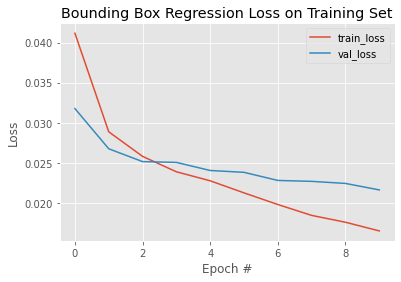

In [48]:
# serialize the model to disk
print("\n[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")
# plot the model training history
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(PLOT_PATH)



[INFO] loading object detector...
/Users/digvijaysingh/object-detection-new/test/4.jpg


2022-10-14 12:13:06.556512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/1g/h8chhdrn69ncdc5v0q1d8v9c0000gn/T/ipykernel_48737/630774803.py:41: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


/Users/digvijaysingh/object-detection-new/test/5.jpg
/Users/digvijaysingh/object-detection-new/test/2.jpg
/Users/digvijaysingh/object-detection-new/test/3.jpg
/Users/digvijaysingh/object-detection-new/test/1.jpg


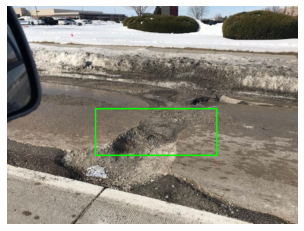

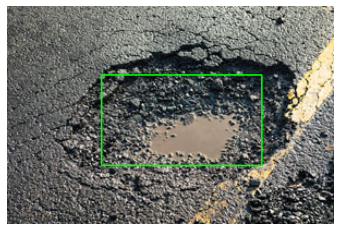

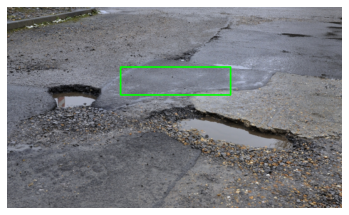

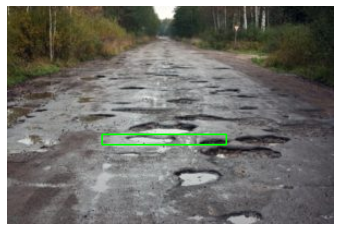

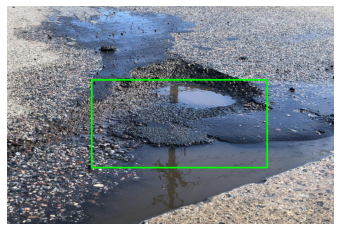

In [49]:
# load our trained bounding box regressor from disk
print("\n[INFO] loading object detector...")
model = load_model(MODEL_PATH)

# loop over the images that we'll be testing using our bounding box regression model
for test_image in fnmatch.filter(os.listdir(TEST_PATH), '*.jpg'):
    
    test_image_path = os.path.join(TEST_PATH, test_image)
    print(test_image_path)

    # load the input image (in Keras format) from disk and preprocess
    # it, scaling the pixel intensities to the range [0, 1]
    image = load_img(test_image_path, target_size=(120, 120))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image)[0]   
    (startX, startY, endX, endY) = preds


    # load the input image (in OpenCV format), resize it such that it
    # fits on our screen, and grab its dimensions
    image = cv2.imread(test_image_path)
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]


    # scale the predicted bounding box coordinates based on the image
    # dimensions
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)

    # draw the predicted bounding box on the image
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # show the output image
    plt.figure()
    plt.axis('off')
    plt.grid(b=None)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.show()

    plt.savefig(os.path.sep.join([BASE_OUTPUT, test_image]))